## Import Libraries

- requirements.txt
    - jupyterlab==4.0.8
    - darts==0.27.0
    - pandas==1.2.3
    - plotly==5.18.0
    - nbformat==5.9.2
    - ipywidgets


In [1]:
!pip install darts plotly nbformat ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.pipeline import Pipeline
from darts.models import TFTModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import StaticCovariatesTransformer, MissingValuesFiller
from tqdm import tqdm

## Read and Preprocess data
https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
path = '/content/gdrive/My Drive/data/time_series/store-sales-time-series-forecasting'
data = pd.read_csv(path + '/train.csv', delimiter=",")
holidays= pd.read_csv(path + '/holidays_events.csv', delimiter=",").drop('type', axis=1)
stores= pd.read_csv(path + '/stores.csv', delimiter=",")
transactions= pd.read_csv(path + '/transactions.csv', delimiter=",")
holidays['holiday_flag']=1
data = data.merge(holidays, on='date', how='left')
data= data.merge(stores, on='store_nbr', how='left')
data = data[data['date']!='2013-01-01'] # Bad data
data= data.merge(transactions, on=['date', 'store_nbr'], how='left')
data['date'] = pd.to_datetime(data["date"])
data = data.drop_duplicates(subset=['date','store_nbr', 'family'], keep='last')
data.loc[data['holiday_flag'].isna(),'holiday_flag']=0
data['year'] = data['date'].dt.year
data.columns

<ipython-input-4-3289485917>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year'] = data['date'].dt.year


Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'locale',
       'locale_name', 'description', 'transferred', 'holiday_flag', 'city',
       'state', 'type', 'cluster', 'transactions', 'year'],
      dtype='object')

In [5]:
data.groupby('store_nbr')['sales'].agg(['count','sum']).sort_values(by='sum',ascending=False).head()
# Store_nbr: 44, 45, 47, 3 are large stores. We will just do the forecasting for them.
data.groupby('family')['sales'].agg(['count','sum']).sort_values(by='sum',ascending=False).head()
# Product family: 'GROCERY I','BEVERAGES','PRODUCE','CLEANING' are large categories. We will just do the forecasting for them.

,count,sum
family,,
GROCERY I,90882,3.434620e+08
BEVERAGES,90882,2.169537e+08
PRODUCE,90882,1.227047e+08
CLEANING,90882,9.752110e+07
DAIRY,90882,6.448757e+07


In [6]:
data = data[ ( data['store_nbr'].isin([44, 45, 47, 3]) ) &
             ( data['family'].isin(['GROCERY I','BEVERAGES','PRODUCE','CLEANING']) ) &
             ( data['date'].dt.year >=2016)
           ]

In [7]:
# Split data into train and test
train = data[data['date']<pd.to_datetime('2017-07-15')]
test = data[data['date']>=pd.to_datetime('2017-07-15')]

In [8]:
[train['date'].nunique(),test['date'].nunique()]

[560, 32]

In [9]:
TIME_COL = "date"
TARGET = "sales"
STATIC_COV = ['store_nbr', 'family']
FREQ = "D"
FORECAST_HORIZON = test['date'].nunique()
COVARIATES = ['onpromotion','holiday_flag']
SCALER = Scaler()
TRANSFORMER = StaticCovariatesTransformer()
PIPELINE = Pipeline([SCALER, TRANSFORMER])

In [10]:
train.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'locale',
       'locale_name', 'description', 'transferred', 'holiday_flag', 'city',
       'state', 'type', 'cluster', 'transactions', 'year'],
      dtype='object')

## Tranform data into Darts format

In [11]:
# read train and test datasets and transform train dataset
train_darts = TimeSeries.from_group_dataframe(df=train,
                                              group_cols=STATIC_COV,
                                              time_col=TIME_COL,
                                              value_cols=TARGET,
                                              freq=FREQ,
                                              fill_missing_dates=True,
                                              fillna_value=0)
test_darts = TimeSeries.from_group_dataframe(df=test,
                                             group_cols=STATIC_COV,
                                             time_col=TIME_COL,
                                             value_cols=TARGET,
                                             freq=FREQ,
                                             fill_missing_dates=True,
                                             fillna_value=0)

In [12]:
[len(train_darts[0]), len(test_darts[0])]

[561, 32]

## Create Covariates

In [13]:
create_covariates = []
for ts in train_darts:
    # Add the month and week as a covariate
    covariate = datetime_attribute_timeseries(
        ts,
        attribute="month",
        one_hot=True,
        cyclic=False,
        add_length=FORECAST_HORIZON,
    )
    covariate = covariate.stack(
        datetime_attribute_timeseries(
            ts,
            attribute="week",
            one_hot=True,
            cyclic=False,
            add_length=FORECAST_HORIZON,
        )
    )
    store = ts.static_covariates['store_nbr'].item()
    family = ts.static_covariates['family'].item()
    # create covariates to fill with interpolation
    other_cov = TimeSeries.from_dataframe(data[(data['store_nbr'] == store) & (data['family'] == family)], time_col=TIME_COL, value_cols=COVARIATES, freq=FREQ, fill_missing_dates=True)
    covariate = covariate.stack(MissingValuesFiller().transform(other_cov))

    create_covariates.append(covariate)

In [14]:
len(create_covariates)

16

In [18]:
create_covariates[0].columns

Index(['month_0', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'week_0', 'week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'week_6',
       'week_7', 'week_8', 'week_9', 'week_10', 'week_11', 'week_12',
       'week_13', 'week_14', 'week_15', 'week_16', 'week_17', 'week_18',
       'week_19', 'week_20', 'week_21', 'week_22', 'week_23', 'week_24',
       'week_25', 'week_26', 'week_27', 'week_28', 'week_29', 'week_30',
       'week_31', 'week_32', 'week_33', 'week_34', 'week_35', 'week_36',
       'week_37', 'week_38', 'week_39', 'week_40', 'week_41', 'week_42',
       'week_43', 'week_44', 'week_45', 'week_46', 'week_47', 'week_48',
       'week_49', 'week_50', 'week_51', 'onpromotion', 'holiday_flag'],
      dtype='object', name='component')

In [19]:
#TimeSeries.pd_dataframe(create_covariates[0]).tail() # This is the old version.
TimeSeries.to_dataframe(create_covariates[0]).tail() # to_dataframe() is the new version of TimeSeries. See https://unit8co.github.io/darts/generated_api/darts.timeseries.html

component,month_0,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,onpromotion,holiday_flag
time,,,,,,,,,,,,,,,,,,,,,
2017-08-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,1.0
2017-08-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0
2017-08-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0
2017-08-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0
2017-08-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,1.0


In [20]:
#TimeSeries.pd_dataframe(train_darts[15]).tail() # pd_dataframe is the old verison
TimeSeries.to_dataframe(train_darts[15]).tail()
# to_dataframe() is the new version of TimeSeries. See https://unit8co.github.io/darts/generated_api/darts.timeseries.html

component,sales
date,
2017-07-10,5062.7570
2017-07-11,4450.1978
2017-07-12,6675.8190
2017-07-13,4157.3610
2017-07-14,4637.2200


## Transform Data

In [21]:
# scale data and transform static covariates
# Notice SCALER is before PIPELINE because PIPELINE includes SCALER
covariates_transformed = SCALER.fit_transform(create_covariates)
train_transformed = PIPELINE.fit_transform(train_darts)

In [22]:
train_transformed[0].columns

Index(['sales'], dtype='object', name='component')

In [23]:
covariates_transformed[0].columns

Index(['month_0', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'week_0', 'week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'week_6',
       'week_7', 'week_8', 'week_9', 'week_10', 'week_11', 'week_12',
       'week_13', 'week_14', 'week_15', 'week_16', 'week_17', 'week_18',
       'week_19', 'week_20', 'week_21', 'week_22', 'week_23', 'week_24',
       'week_25', 'week_26', 'week_27', 'week_28', 'week_29', 'week_30',
       'week_31', 'week_32', 'week_33', 'week_34', 'week_35', 'week_36',
       'week_37', 'week_38', 'week_39', 'week_40', 'week_41', 'week_42',
       'week_43', 'week_44', 'week_45', 'week_46', 'week_47', 'week_48',
       'week_49', 'week_50', 'week_51', 'onpromotion', 'holiday_flag'],
      dtype='object', name='component')

In [24]:
# TimeSeries.pd_dataframe(covariates_transformed[0]) # 143 weeks from 2010-02-05 to 2012-10-26 #pd_dataframe() is the old version
TimeSeries.to_dataframe(covariates_transformed[0]) # 143 weeks from 2010-02-05 to 2012-10-26 # to_dataframe() is the new version

component,month_0,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,onpromotion,holiday_flag
time,,,,,,,,,,,,,,,,,,,,,
2016-01-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0
2016-01-02,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041237,0.0
2016-01-03,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020619,0.0
2016-01-04,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041237,0.0
2016-01-05,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041237,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.134021,1.0
2017-08-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.123711,0.0
2017-08-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.134021,0.0


In [25]:
[len(covariates_transformed[0]), len(train_transformed[0])]

[593, 561]

## TFT

- The sample model is not optimized yet. You will need to fine-tune the model with more epochs and hyperparameters.

In [37]:
TFT_params = {
    "input_chunk_length": 52,
    "output_chunk_length": FORECAST_HORIZON,
    "hidden_size": 2,
    "lstm_layers": 2,
    "num_attention_heads": 1,
    "dropout": 0.1,
    "batch_size": 16,
    "n_epochs": 10,
    "likelihood": QuantileRegression(quantiles=[0.25, 0.5, 0.75]),
    "random_state": 42,
    "use_static_covariates": True,
    "optimizer_kwargs": {"lr": 1e-3},
}

tft_model = TFTModel(**TFT_params)
tft_model.fit(train_transformed, # The training periods
              future_covariates=covariates_transformed, # The entire periods
              verbose=False)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


TFTModel(output_chunk_shift=0, hidden_size=2, lstm_layers=2, num_attention_heads=1, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=QuantileRegression(quantiles=[0.25, 0.5, 0.75], prior_strength=1.0), norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=52, output_chunk_length=32, batch_size=16, n_epochs=10, random_state=42, optimizer_kwargs={'lr': 0.001})

In [38]:
# Get the prediction that is scaled
scaled_pred = tft_model.predict(n=FORECAST_HORIZON,
                                series=train_transformed, # The training periods
                                num_samples=50,
                                future_covariates=covariates_transformed # The entire periods
                               )


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [39]:
len(scaled_pred[0])

32

In [40]:

# Transform the scaled prediction to the normal scale
prediction = PIPELINE.inverse_transform(scaled_pred)

### Plotting

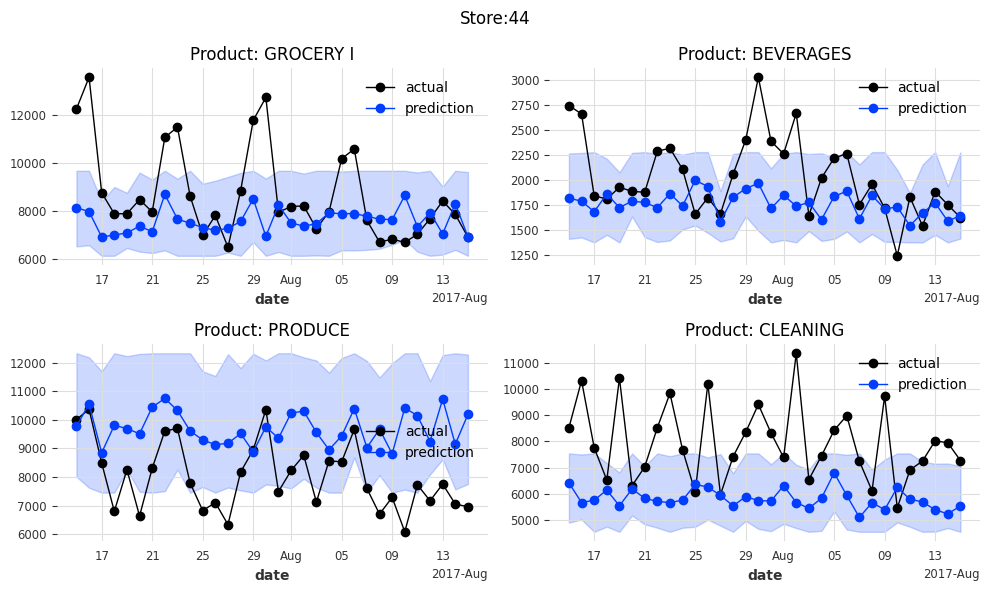

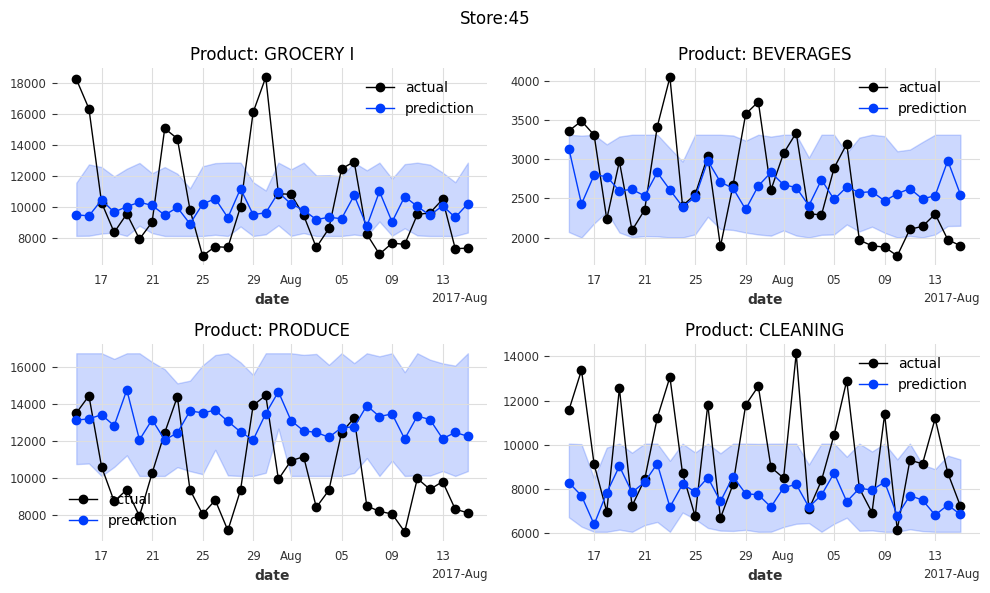

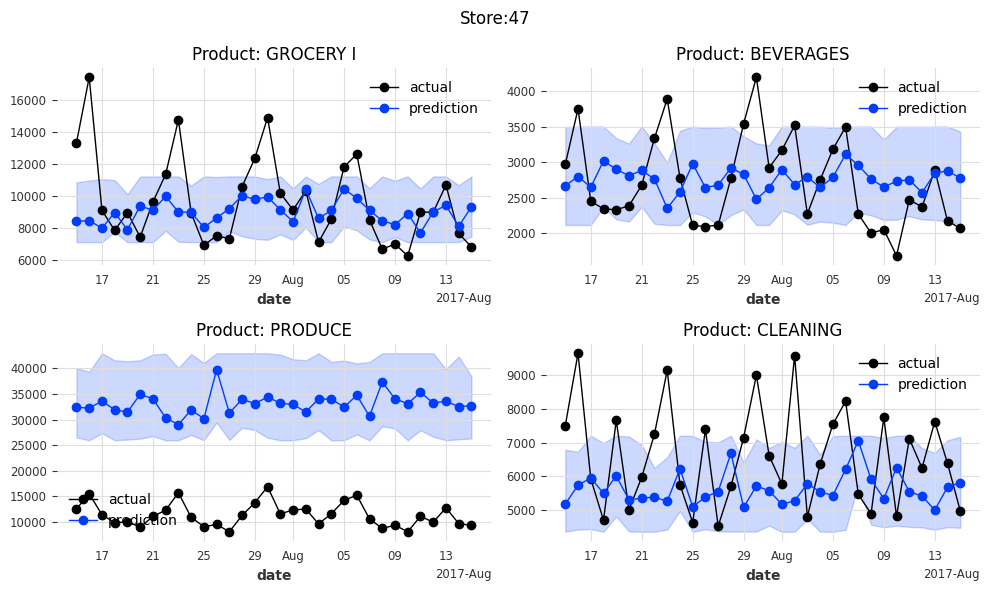

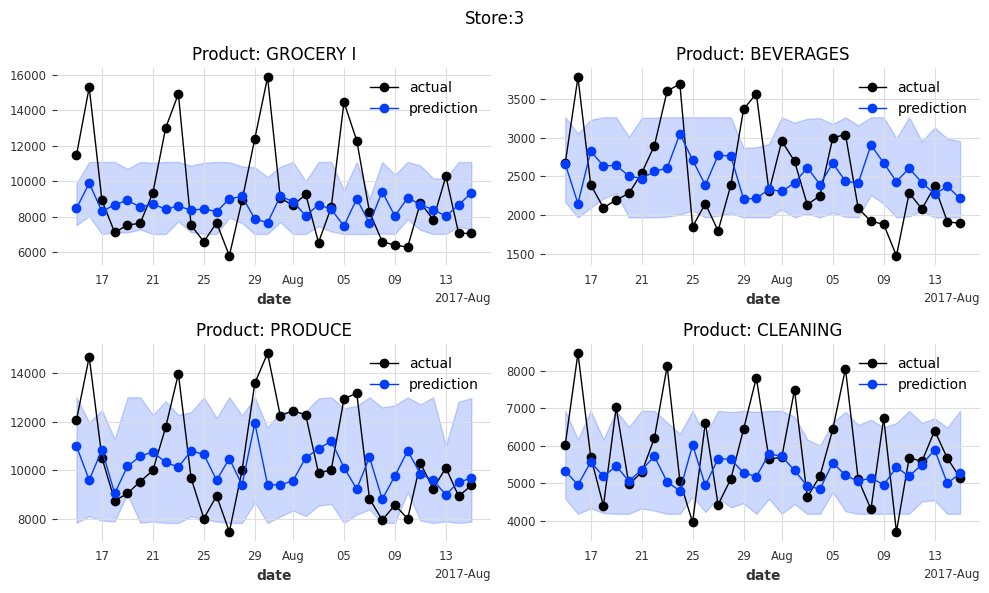

In [41]:
def plot_it():
    fig, axs = plt.subplots(2, 2, figsize=(10, 6), dpi=100)
    ax0 = axs[0,0]
    ax1 = axs[0,1]
    ax2 = axs[1,0]
    ax3 = axs[1,1]

    plt.suptitle("Store:" +  str(store) , fontsize=12)

    val0[: pred0.end_time()].plot(ax=ax0, label="actual", marker='o', linewidth=1)
    pred0.plot(ax = ax0, low_quantile=0.25, high_quantile=0.75, label="prediction", marker='o',linewidth=1,alpha=0.2 )
    ax0.title.set_text('Product: '+family[0])

    val1[: pred1.end_time()].plot(ax=ax1, label="actual", marker='o', linewidth=1)
    pred1.plot(ax = ax1, low_quantile=0.25, high_quantile=0.75, label="prediction", marker='o',linewidth=1,alpha=0.2 )
    ax1.title.set_text('Product: '+family[1])

    val2[: pred2.end_time()].plot(ax=ax2, label="actual", marker='o', linewidth=1)
    pred2.plot(ax = ax2, low_quantile=0.25, high_quantile=0.75, label="prediction", marker='o',linewidth=1,alpha=0.2 )
    ax2.title.set_text('Product: '+family[2])

    val3[: pred3.end_time()].plot(ax=ax3, label="actual", marker='o', linewidth=1)
    pred3.plot(ax = ax3, low_quantile=0.25, high_quantile=0.75, label="prediction", marker='o',linewidth=1,alpha=0.2 )
    ax3.title.set_text('Product: '+family[3])
    fig.tight_layout()
    plt.show()


store_nbr = [44, 45, 47, 3]
family = ['GROCERY I', 'BEVERAGES', 'PRODUCE', 'CLEANING']

for i in range(0,16,4):
    k = int(i/4)
    store = store_nbr[k]
    pred0 = prediction[i]
    pred1 = prediction[i+1]
    pred2 = prediction[i+2]
    pred3 = prediction[i+3]
    val0 = test_darts[i]
    val1 = test_darts[i+1]
    val2 = test_darts[i+2]
    val3 = test_darts[i+3]
    plot_it()

## Explainability

In [42]:
from darts.explainability import TFTExplainer

explainer = TFTExplainer(
    tft_model,
    background_series=train_transformed[1],
    background_future_covariates=covariates_transformed[1],
)
explainability_result = explainer.explain()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

### Encoder Importance

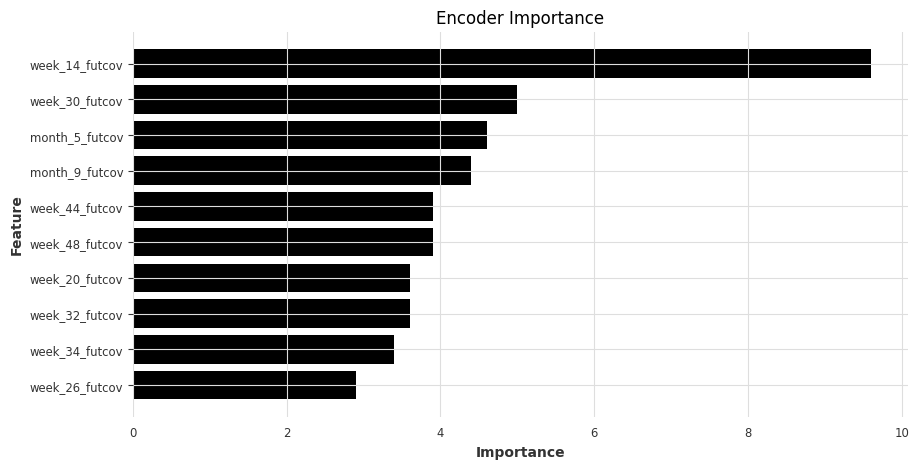

In [43]:
plt.rcParams["figure.figsize"] = (10,5)
plt.barh(data=explainer._encoder_importance.melt().sort_values(by='value').tail(10), y='variable', width='value')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Encoder Importance')
plt.show()

### Decoder Importance

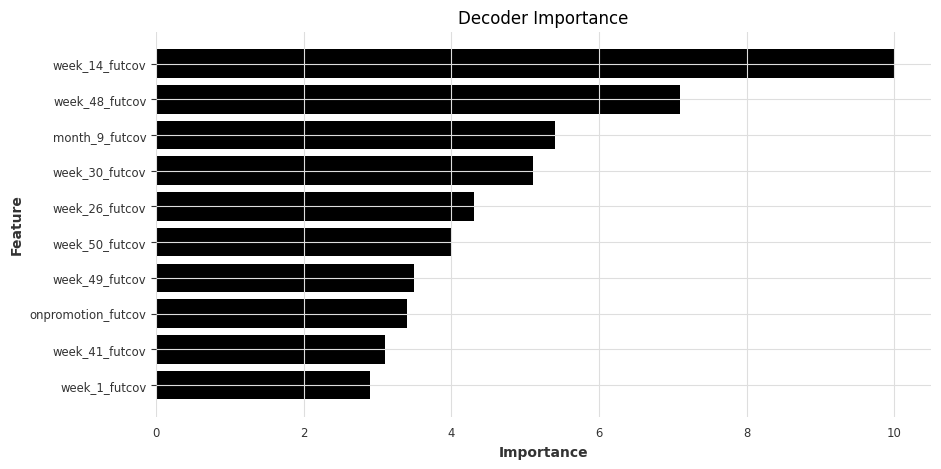

In [44]:
plt.rcParams["figure.figsize"] = (10,5)
plt.barh(data=explainer._decoder_importance.melt().sort_values(by='value').tail(10), y='variable', width='value')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Decoder Importance')
plt.show()

### Static Cov Importance

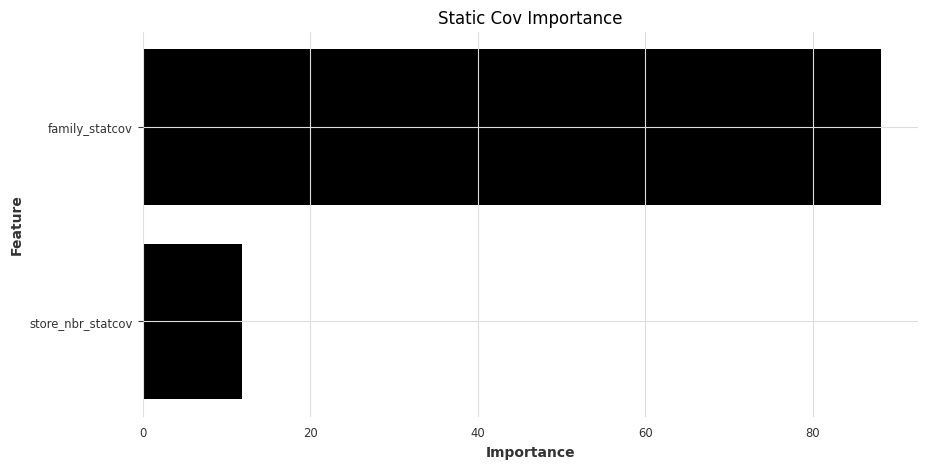

In [45]:
plt.rcParams["figure.figsize"] = (10,5)
plt.barh(data=explainer._static_covariates_importance.melt().sort_values(by='value').tail(10), y='variable', width='value')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Static Cov Importance')
plt.show()

### Time Importance

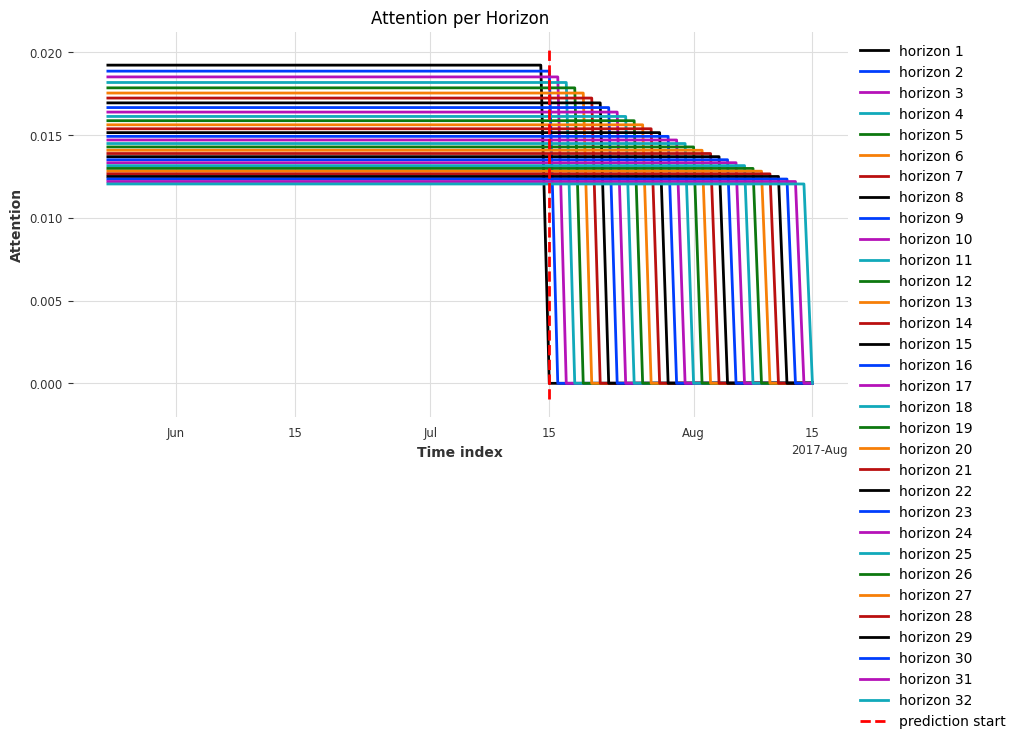

<Axes: title={'center': 'Attention per Horizon'}, xlabel='Time index', ylabel='Attention'>

In [46]:
explainer.plot_attention(explainability_result, plot_type="all", show_index_as='time')